In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
from scipy.optimize import curve_fit
import math
from scipy.interpolate import splrep, BSpline
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/diel_workshop')
from diel_tools import *
from fig_tools import *
from tsd_functions import *

In [2]:
# read in data
cruise_daily=pd.read_pickle('/Users/Kathy/Desktop/UW/seaflow/decomposition_project/data/G1_models_results.pkl')
# adjust par so that night values are all 0
cruise_daily['adj_par']=np.where(cruise_daily['night']=='night',cruise_daily['par']==0, cruise_daily['par'])

## Smoothing data

In [3]:
# helper function to resample and interpolate data on an hourly resolution
def resample_hourly(df, pop):
    df=df.loc[df['lat'].notnull()]
    df['time'] = pd.to_datetime(df['time'])
    # set the index as time
    df_res = df.set_index('time')
    df_res.index = pd.to_datetime(df_res.index)
    # interpolate by population 
    df_sub = df_res[df_res['pop']==pop]
    df_sub=df_sub.resample('1H').mean()
    return(df_sub)

### spline interpolation

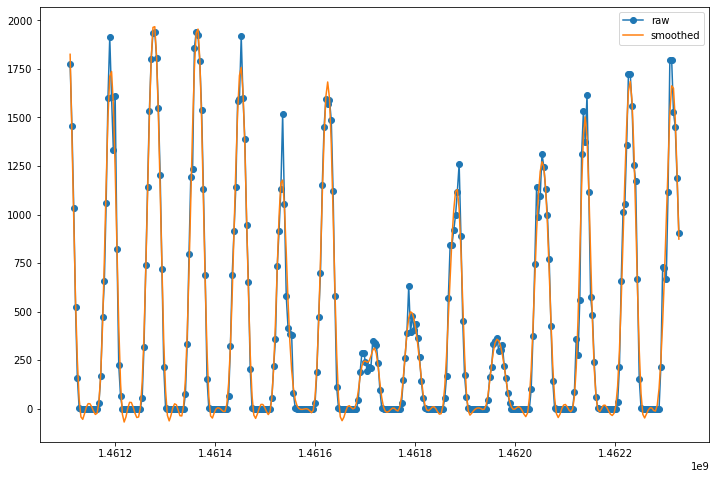

In [4]:
from scipy.interpolate import UnivariateSpline
test_par=cruise_daily.copy()
# convert time to seconds
epoch = pd.to_datetime('1970-01-01')
test_par['seconds'] = round((test_par['time'].dt.tz_localize(None) - epoch).dt.total_seconds())
# set x and y
x=test_par.loc[test_par['pop']=='prochloro','seconds']
y=test_par.loc[test_par['pop']=='prochloro','adj_par']
# calculate cubic spline
spl = UnivariateSpline(x, y, k=3,s=len(x))
factor=10000000/4.8
spl.set_smoothing_factor(factor)
# plot spline results
fig,axs=plt.subplots(figsize=(12,8))
axs.plot(x,y,label='raw',marker='o')
axs.plot(x,spl(x),label='smoothed')
axs.legend()

In [5]:
from sklearn.model_selection import LeaveOneOut
from scipy import interpolate
loo = LeaveOneOut()

In [6]:
x_range=range(0,len(x))
lambs = np.array([313,323,333,353,363])
for i in lambs:
    error = []
    for trg, tst in loo.split(x_range):
        spl = interpolate.splrep(x[trg], y[trg],s=i)
        # fit to data
        pred = interpolate.splev(x[tst],spl)[0]
        true = y[tst].values[0]
        error.append((pred - true)**2)
    mse = np.mean(error)
    print(f'lamb: {i}, mse: {mse}')

lamb: 313, mse: 8548.517364783716
lamb: 323, mse: 8549.046794156497
lamb: 333, mse: 8549.800956982162
lamb: 353, mse: 8547.820094662087
lamb: 363, mse: 8548.016870790609


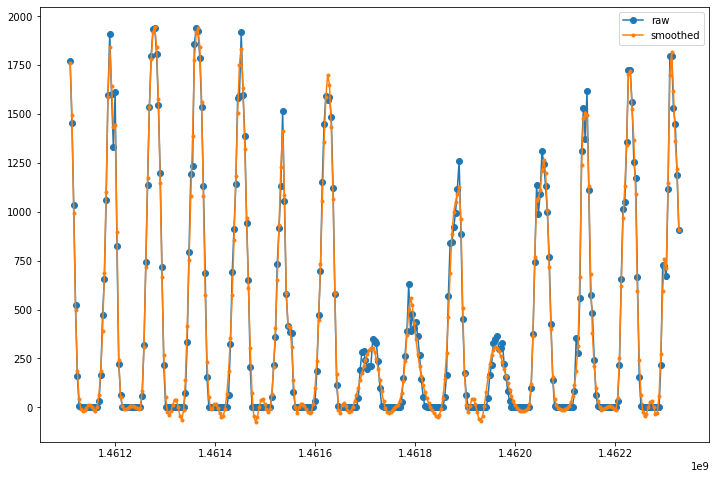

In [7]:
# best one so far
spl = interpolate.splrep(x, y, s=1000000, k=3)
y_hat = interpolate.splev(x, spl)
# plot spline results
fig,axs=plt.subplots(figsize=(12,8))
axs.plot(x,y,label='raw',marker='o')
axs.plot(x,y_hat,label='smoothed',marker='.')
axs.legend()

### Low pass filters

In [8]:
from scipy.signal import butter,filtfilt
# helper function for butterworth filter
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    print(normal_cutoff)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [553]:
T = len(pd.unique(cruise_daily['time']))*3600      # Sample Period (# seconds on cruise)
fs = 1/3600     # sample rate, Hz (# hours sampled` a day)
cutoff = 1/(24*3600) # desired cutoff frequency of the filter (at which freq should be smoothed out)
nyq = 0.5 * fs  # Nyquist Frequency
order = 3       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [554]:
T = len(pd.unique(cruise_daily['cruise_day']))      # Sample Period (# seconds on cruise)
fs = 24     # sample rate, Hz (# hours sampled` a day)
cutoff = 2 # desired cutoff frequency of the filter (at which freq should be smoothed out)
nyq = 0.5 * fs  # Nyquist Frequency
order = 4       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

0.16666666666666666


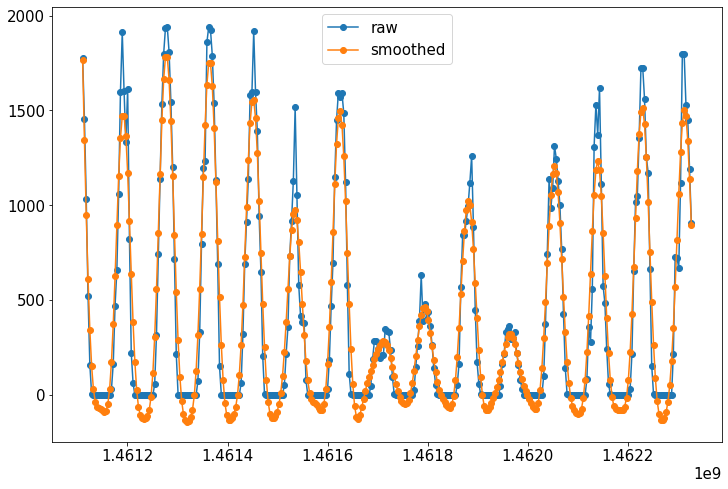

In [555]:
y_butter=butter_lowpass_filter(y, cutoff, fs, order)
# plot lowpass results
fig,axs=plt.subplots(figsize=(12,8))
axs.plot(x,y,label='raw',marker='o')
axs.plot(x,y_butter,label='smoothed',marker='o')
axs.legend()

### Check if smoothed par returns better growth rates 

In [12]:
# set adj_par column values
cruise_daily.loc[np.arange(0,int(len(cruise_daily)/2)),'adj_par']=y_hat
cruise_daily.loc[np.arange(int(len(cruise_daily)/2),len(cruise_daily)),'adj_par']=y_hat
# reset night time values
cruise_daily['adj_par']=np.where(cruise_daily['night']=='night',cruise_daily['adj_par']==0, cruise_daily['adj_par'])

In [13]:
cruise_sorted=cruise_daily.sort_values(by='time')

In [14]:
# impute negative values for now until i think of something better
neg_ind=cruise_sorted[cruise_sorted['adj_par']<0].index
cruise_sorted.loc[neg_ind,'adj_par']=cruise_sorted.loc[neg_ind,'par']

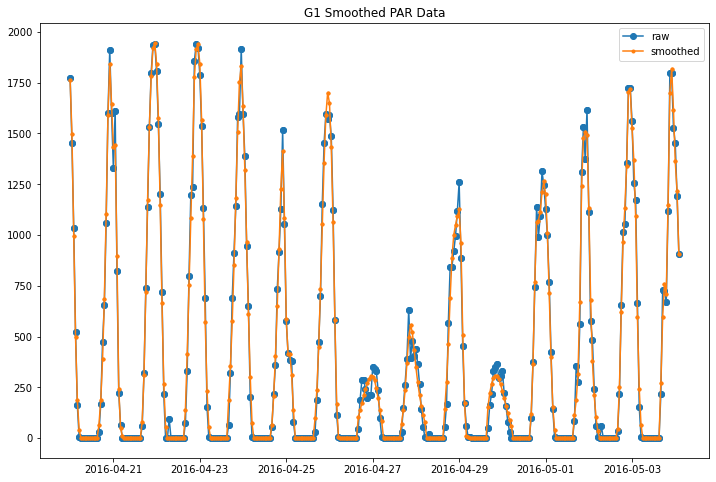

In [15]:
# plot spline results
fig,axs=plt.subplots(figsize=(12,8))
axs.plot(cruise_sorted['time'],cruise_sorted['par'],label='raw',marker='o')
axs.plot(cruise_sorted['time'],cruise_sorted['adj_par'],label='smoothed',marker='.')
axs.set_title('G1 Smoothed PAR Data')
axs.legend()

## Estimating growth

In [26]:
from scipy.optimize import curve_fit
import math

# helper function to find the closest value in a list
def closest(lst, K):     
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

# platt equation (no photoinhibition)
## KI=half saturation constant, where light = 1/2P
def platt1(x, p_max, ki):
    return (p_max*x)/(ki+x)

# platt equation (with photoinhibition)
def platt2(i, p_max, alpha,beta):
    return (p_max*(1-math.e**(-alpha*i/p_max))*math.e**(-beta*i/p_max))

# helper function to optimize platt equation where x=par, y=growth rate
def optimize_pi(x, y, method="platt1"):
    # set initial guess params for pmax
    p_max=np.max(y)
    if method=="platt1":
        ki=x[y[y==p_max].index].values[0]/2
        # call curve fit and set initial params to guesses of best fit per day
        ## initialized values MUST fit within bounds or else this will fail! ##
        parameters, covariance=curve_fit(platt1, list(x), list(y), p0=[p_max, ki],bounds=(0, [0.3,1500]))
        # fit parameters
        fit_p_max = parameters[0]
        fit_ki = parameters[1]
        # fit model to new parameters
        fit_platt = platt1(x, fit_p_max, fit_ki)
    elif method=="platt2":
        # set photoinhibition after pmax
        pmax_i=x[y[y==p_max].index].values[0]
        # set to some scale first
        alpha=0.00005
        beta=0.00005
        parameters, covariance=curve_fit(platt2, 
                                         list(x), 
                                         list(y),
                                         p0=[p_max,alpha,beta],
                                         bounds=(0, [0.3,alpha*10,beta*1000]))
        fit_p_max = parameters[0]
        fit_alpha = parameters[1]
        fit_beta = parameters[2]
        # fit model to new parameters
        fit_platt = platt2(x, fit_p_max, fit_alpha, fit_beta)
    else:
        print("Enter valid method")
        exit
    return fit_platt,parameters

# helper function to add PI values to inputted dataframe
def get_pi_vals(df,col,pop,method='platt1'):
    pi_df=df
    pop_split=pi_df.loc[(pi_df['pop']==pop)]
    pop_split['platt']=0
    for day in pd.unique(pop_split['cruise_day']):
        # subdivide df by unique day
        sub=pop_split.loc[pop_split['cruise_day']==day]
        xdata=sub['adj_par']
        ydata=sub[col]
        # calculate pi fit
        fit,params=optimize_pi(xdata,ydata,method=method)
        pop_split.loc[sub.index, 'platt']=fit
        pop_split.loc[sub.index, 'pmax']=params[0]
        # calculate ssr as error metric
        error=ssr(np.ma.masked_invalid(ydata),np.ma.masked_invalid(fit))
        #np.nanmean(np.ma.masked_invalid(np.abs((ydata - fit) / ydata))) * 100
        pop_split.loc[sub.index, 'ssr']=error
        if method=='platt1':
            pop_split.loc[sub.index, 'k']=params[1]
        else:
            pop_split.loc[sub.index, 'alpha']=params[1]
            pop_split.loc[sub.index, 'beta']=params[2]
    return pop_split

In [ ]:
ssr(y,y_platt)

In [358]:
ssr(y,y_platt)

0.0022201534506310263

In [380]:
ssr(y,y_fit)

0.003070370996809451

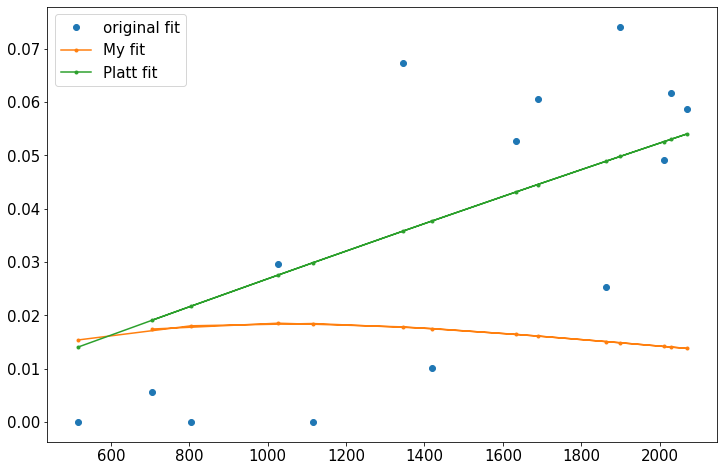

In [561]:
day1=all_days.loc[(all_days['pop']=='prochloro')&(all_days['cruise_day']==9)]
x=day1['adj_par']
y=day1['hourly_growth']
alpha=0.00005
beta=0.00005
pmax=np.max(y)
y_platt=platt2(x,pmax,alpha,beta)
parameters, covariance=curve_fit(platt2, 
                                 list(x), 
                                 list(y),
                                 p0=[p_max,alpha,beta],
                                 bounds=([0,0,0], [0.5,alpha*10,beta*1000]))
fit_pmax,fit_alpha,fit_beta=parameters
# fit based on curve_fit params
y_fit=platt2(x,fit_pmax,fit_alpha,fit_beta)
fig,axs=plt.subplots(figsize=(12,8))
axs.plot(x,y,label='original fit', marker='o',linestyle='')
axs.plot(x,y_platt,label='My fit', marker='.')
axs.plot(x,y_fit,label='Platt fit', marker='.')
axs.legend()

In [441]:
# platt equation (with photoinhibition)
def platt2(i, p_max, alpha,beta):
    return (p_max*(1-math.e**(-alpha*i/p_max))*math.e**(-beta*i/p_max))

0.0001651906833885433

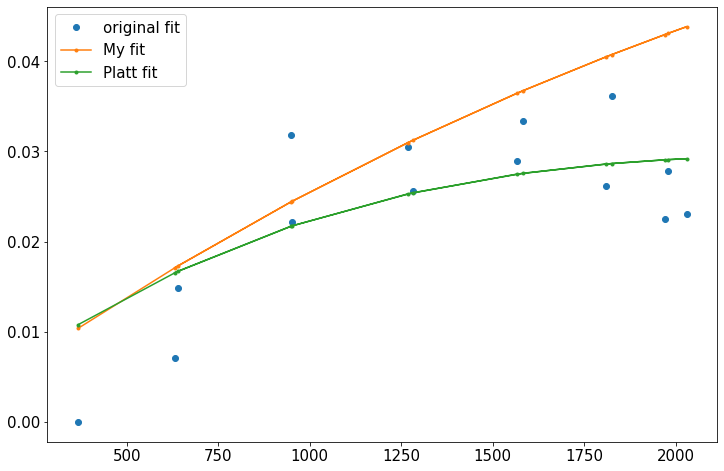

In [485]:
day1=all_days.loc[(all_days['pop']=='prochloro')&(all_days['cruise_day']==1)]
x=day1['adj_par']
y=day1['hourly_growth']
alpha=0.00003
beta=0.00005
pmax=0.4
y_platt=platt2(x,pmax,alpha,beta)
parameters, covariance=curve_fit(platt2, 
                                 list(x), 
                                 list(y),
                                 p0=[p_max,alpha,beta],
                                 bounds=([0,0,0], [0.5,alpha*10,beta*1000]))
fit_pmax,fit_alpha,fit_beta=parameters
# fit based on curve_fit params
y_fit=platt2(x,fit_pmax,fit_alpha,fit_beta)
fig,axs=plt.subplots(figsize=(12,8))
axs.plot(x,y,label='original fit', marker='o',linestyle='')
axs.plot(x,y_platt,label='My fit', marker='.')
axs.plot(x,y_fit,label='Platt fit', marker='.')
axs.legend()

In [18]:
## helper function to do a centered difference to calculate growth rate, edges calculated by first order diff
# input: df=dataframe with diel component, col=specififying diel component of particular model
def centered_diff(df,col):
    return(pd.Series(np.gradient(df[col]), name='hourly_growth'))

In [19]:
hourly=cruise_sorted.sort_values(by='time').groupby(['pop']).apply(lambda v: 
                                     centered_diff(v,'3roll_diel')).unstack().reset_index()
hourly=hourly.drop(columns=['hourly_growth']).rename(columns={0:'hourly_growth'})
hourly['time']=cruise_sorted.sort_values(by='time').reset_index()['time']
days_growth=cruise_sorted.merge(hourly, how='left')
# get only complete days based on cruise days (sunrise->sunset)
all_days=get_complete_days(days_growth)

In [20]:
all_days['hourly_growth']=np.where(all_days['hourly_growth']<0, all_days['hourly_growth']==0,all_days['hourly_growth'])

In [28]:
# for now, make all negative growth values 0 to see what happens
np.where(all_days['hourly_growth']<0, all_days['hourly_growth']==0,all_days['hourly_growth'])
# split by pop, return values from curve_fit() optimization of platt function
pro=get_pi_vals(all_days,'hourly_growth','prochloro','platt2')
syn=get_pi_vals(all_days,'hourly_growth','synecho','platt2')
# put params together
all_pops=pd.concat([pro,syn])
# make figure for Pro via plotly
name='G1'
pro['lat']=pro['lat'].astype(float)
pro_fig=px.scatter(pro, x='adj_par',y='platt',facet_col='cruise_day',facet_col_wrap=6,
        facet_row_spacing=0.03, width=1000, height=800, title=f'{name} Prochlorococcus',
                   color='lat',color_continuous_scale=px.colors.sequential.Viridis)
pro_fig=pretty_plot(pro_fig, rescale_y=False,x_label='PAR',y_label='Hourly Cellular Growth Rate')
pro_fig.show()
# make figure for Syn
syn['lat']=syn['lat'].astype(float)
syn_fig=px.scatter(syn, x='adj_par',y='platt',facet_col='cruise_day',facet_col_wrap=6,
facet_row_spacing=0.03,width=1000, height=800, title=f'{name} Synechococcus',
                   color='lat',color_continuous_scale=px.colors.sequential.Viridis)
syn_fig=pretty_plot(syn_fig, rescale_y=False,x_label='PAR',y_label='Hourly Cellular Growth Rate')
syn_fig.show()

In [ ]:
## for platt1
test=all_pops[['time','pop','cruise_day','adj_par','platt','hourly_growth','k','pmax','ssr']]
test=test[test['pop']=='prochloro']
g=sns.FacetGrid(
    test, col='cruise_day',col_wrap=5,
    hue="cruise_day", height=4, sharey='col')
g.map_dataframe(sns.lineplot,x='adj_par',y='platt',legend=False)
g.map_dataframe(sns.scatterplot,x='adj_par',y='hourly_growth', hue='pop',legend=False)
# set ylim
g.set(ylim=(-0.05, 0.1))
# add title
g.fig.suptitle('Diel 2015 Prochlococcus Growth Curve')

# map each pmax to each facet plot
k_position = test.drop_duplicates(subset=['k','pop','time']).sort_values(by='cruise_day')['k']
pmax_position = test.drop_duplicates(subset=['pmax','pop','time']).sort_values(by='cruise_day')['pmax']
mape_position = test.drop_duplicates(subset=['mape','pop','time']).sort_values(by='cruise_day')['mape']

for ax, pos1, pos2,mape in zip(g.axes.flat, k_position, pmax_position,mape_position):
#for ax, pos1, pos2, pos3 in zip(g.axes.flat, pmax_position,alpha_position,beta_position):
    l0=ax.axhline(y=pos2, color='g', linestyle=':', label=f'Pmax={np.round(pos2,3)}')
    l1=ax.axvline(x=pos1, color='r', linestyle=':', label=f'K={np.round(pos1,2)}')
    # add text for mape
    extrastring=f'mape: {np.round(mape,3)}'
    lns = [l0,l1]
    lns.append(mpatches.Patch(color='none', label=extrastring))
    labs = [l.get_label() for l in lns]
#     ax.legend(lns, labs)
plt.tight_layout()
plt.rcParams.update({'font.size':15})

In [589]:
y=test.loc[test['cruise_day']==6, 'hourly_growth']
y_fit=test.loc[test['cruise_day']==6, 'platt']
ssr(y,y_fit)
#0.00362 syn day10
#0.0064  pro
#0.0016 pro day6
#0.0026 syn

0.0025357650589584607

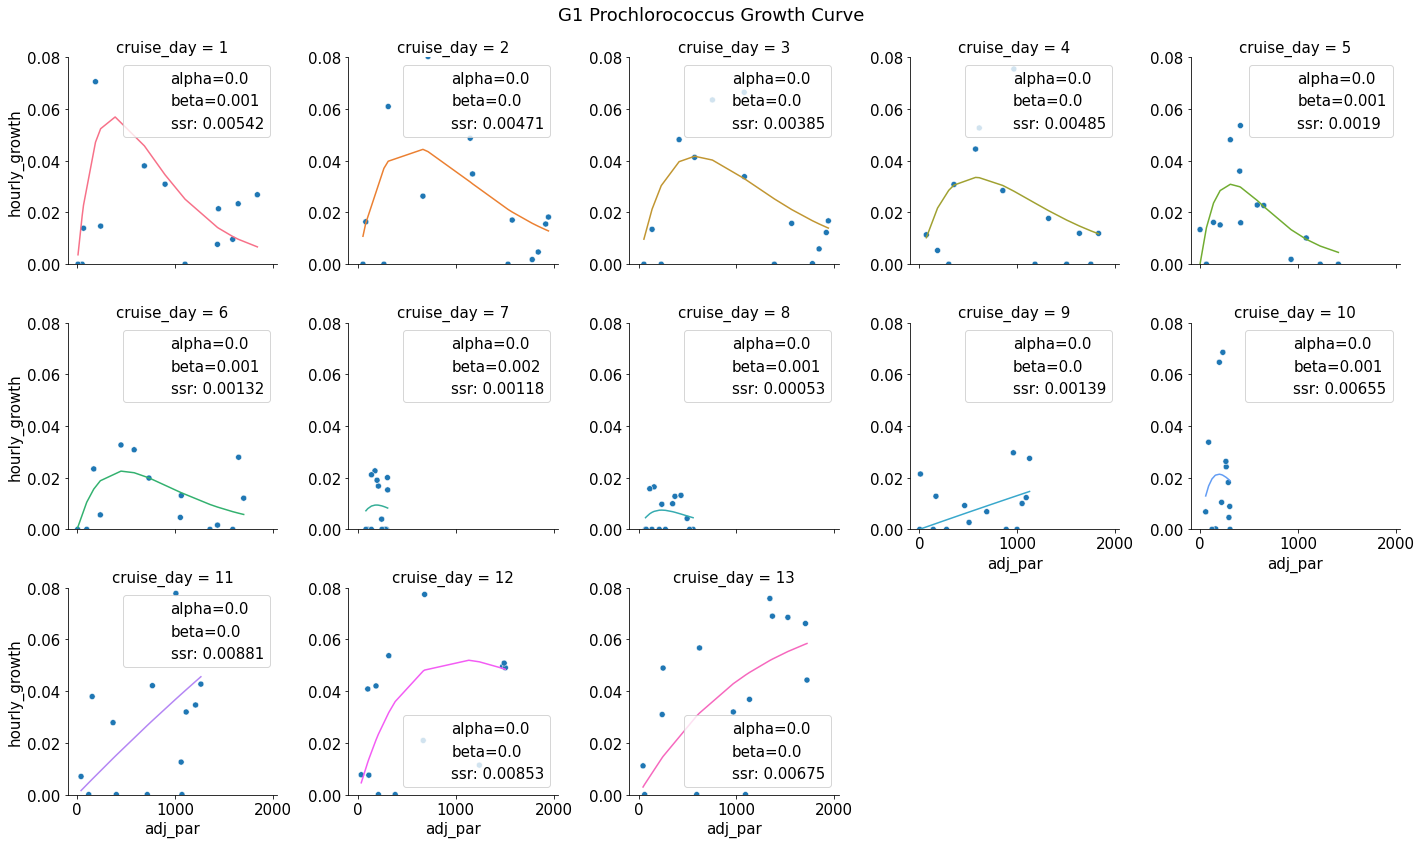

In [43]:
## for platt2
test=all_pops[['time','pop','cruise_day','adj_par','platt','hourly_growth','alpha','beta','pmax','ssr']]
test=test[test['pop']=='prochloro']
g=sns.FacetGrid(
    test, col='cruise_day',col_wrap=5,
    hue="cruise_day", height=4, sharey='col')
g.map_dataframe(sns.lineplot,x='adj_par',y='platt',legend= False)
g.map_dataframe(sns.scatterplot,x='adj_par',y='hourly_growth', hue='pop',legend= False)
# add title
g.fig.suptitle('G1 Prochlorococcus Growth Curve')
# set ylim
g.set(ylim=(0, 0.08))

# map each pmax to each facet plot
alpha_position = test.drop_duplicates(subset=['alpha','pop']).sort_values(by='cruise_day')['alpha']
beta_position = test.drop_duplicates(subset=['alpha','beta','pop']).sort_values(by='cruise_day')['beta']
pmax_position = test.drop_duplicates(subset=['pmax','pop']).sort_values(by='cruise_day')['pmax']
ssr_position = test.drop_duplicates(subset=['ssr','pop']).sort_values(by='cruise_day')['ssr']

#for ax, pos1, pos2 in zip(g.axes.flat, k_position, pmax_position):
for ax, pos1, pos2, pos3,ssr in zip(g.axes.flat, pmax_position,alpha_position,beta_position,ssr_position):
#     l1=ax.axhline(y=pos1, color='g', linestyle=':', label=f'Pmax={np.round(pos1,2)}')
    alpha=f'alpha={np.round(pos2,3)}'
    beta=f'beta={np.round(pos3,3)}'
    ssr=f'ssr: {np.round(ssr,5)}'
    lns = []
    strings=[mpatches.Patch(color='none', label=alpha),mpatches.Patch(color='none', label=beta),
               mpatches.Patch(color='none', label=ssr)]
    for string in strings:
        lns.append(string)
    labs = [l.get_label() for l in lns]  
    ax.legend(lns, labs, loc=0)
plt.tight_layout()
plt.rcParams.update({'font.size':15})

## PI curve simulation experiments
Testing whether the optimization function or the platt equation is working like it should be <br>
Example from [blog](https://danielmuellerkomorowska.com/2020/08/11/a-curve-fitting-guide-for-the-busy-experimentalist/)

In [ ]:
## KI=half saturation constant, where light = 1/2P
def platt1(x, p_max, ki):
    return (p_max*x)/(ki+x)

# platt equation (with photoinhibition)
def platt2(i, p_max, alpha,beta):
    return (p_max*(1-math.e**(-alpha*i/p_max))*math.e**(-beta*i/p_max))

In [ ]:
#p0=[p_max,alpha,beta],bounds=(0, [0.3,alpha*10,beta*1000])

### first generate some data from platt equation

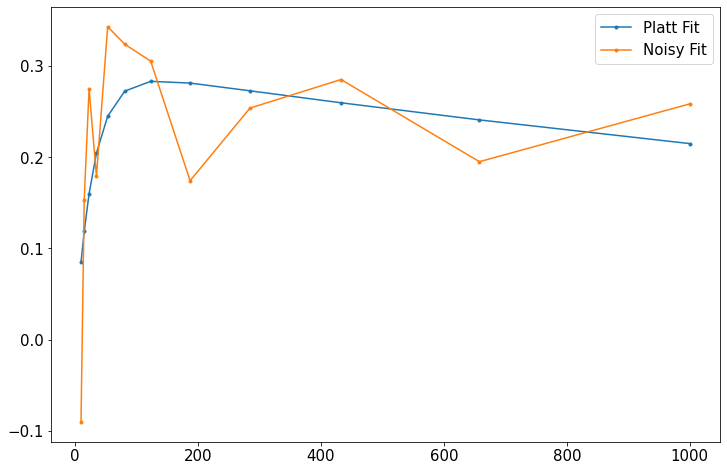

In [297]:
## Parameters for the platt2 function
# low pmax -> lower pmax and slightly lower pmin at time 0 (smaller diff between pmin and pmax), becomes flat
# or exponentially decreasing when too low 
# high pmax -> exponentially blows up pmax by even 0.05 difference and decreases photoinhibion
real_pmax=0.3
pmax2=0.3
# lower alpha -> lower pmin at time 0 (increases difference between pmin and pmax) and slightly lower pmax
# curve tends to flatten out when alpha is too low, but no inflection point
# higher alpha -> higher pmin at time 0 until pmax is at time 0 if alpha is too high (linearly decreasing)
real_alpha= 0.01
# lower beta -> shallower attenuation, saturates flatly when too low (not photoinhibition)
# higher beta -> steeper attenuation at lower light and no pmin at time 0 if too high
real_beta=0.0001
 
# Sample exp_decay function and add noise
np.random.seed(100)
dt=0.02
x = np.logspace(1, 3.0, num=12)
noise=np.random.normal(scale=0.1, size=x.shape[0])
y = platt2(x, real_pmax, real_alpha, real_beta)
y_noisy = y + noise
fig,axs=plt.subplots(figsize=(12,8))
axs.plot(x,y,label='Platt Fit',marker='.')
axs.plot(x,y_noisy, label='Noisy Fit', marker='.')
# axs.set_ylim(0,0.35)
axs.legend()

In [23]:
def ssr(y, fy):
    """Sum of squared residuals"""
    return ((y - fy) ** 2).sum()
# no_bounds=ssr(y,y_fit)

In [277]:
no_bounds

0.04527348834339992

In [302]:
real_beta

0.0001

In [301]:
fit_beta

0.0001000000000000001

SSR: 1.1170393677445968e-32


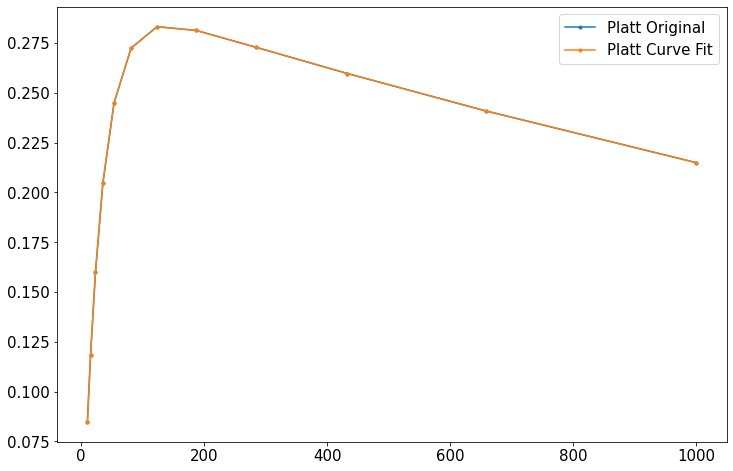

In [298]:
# Use scipy.optimize.curve_fit to fit parameters to generated data
alpha=0.05
beta=0.0005
p_max=np.max(y)
popt, pcov = curve_fit(platt2, x, y, 
                       # initial values of alpha and beta matter a lot!!!
                       p0=[p_max,alpha,beta])
#                        bounds=(0, [0.5,alpha*10,beta*1000]))
# how well do fit parameters line up with the original?
fit_pmax, fit_alpha, fit_beta = popt
# add bounds
y_fit = platt2(x, fit_pmax, fit_alpha, fit_beta)
# with bounds
# plot against each other
fig,axs=plt.subplots(figsize=(12,8))
axs.plot(x,y,label='Platt Original',marker='.')
axs.plot(x,y_fit, label='Platt Curve Fit', marker='.')
# axs.set_ylim(0,0.35)
axs.legend()
# print the error
bounds=ssr(y,y_fit)
print(f'SSR: {bounds}')

In [ ]:
# Use scipy.optimize.curve_fit to fit parameters to noisy data
popt, pcov = curve_fit(platt2, x, y_noisy)
fit_pmax, fit_alpha, fit_beta = popt
# Sample exp_decay with optimized parameters
y_fit = platt2(x, fit_pmax, fit_alpha, fit_beta)
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x, y_noisy,
           alpha=0.8,
           color= "#1b9e77",
           label="Exponential Decay + Noise")
ax.plot(x, y,
        color="#d95f02",
        label="Exponential Decay", marker='.')
ax.plot(x, y_fit,
        color="#7570b3",
        label="Fit")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.set_title("Curve Fit Platt2")